In [2]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from unidip import UniDip
from sklearn.svm import LinearSVC
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

load data

In [1]:
rootpath = "../data"
sub_id = "dy009"
samp_freq = 30_000

In [3]:
# load unsorted data
spikes_indices, _, np1_channel_map, stimulus_onset_times, _, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=True, samp_freq=samp_freq)

In [4]:
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

In [5]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = True)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


In [6]:
triaged_features = np.load('../data/dy009/unsorted/triage_results/triaged_features.npy')
triage_idx_keep = np.load('../data/dy009/unsorted/triage_results/triage_idx_keep.npy')
triage_low_ptp_filter = np.load('../data/dy009/unsorted/triage_results/triage_low_ptp_filter.npy')

In [7]:
triaged_indices = spikes_indices.copy()[triage_low_ptp_filter]
triaged_indices = triaged_indices[triage_idx_keep]

In [8]:
triaged_unsorted = np.hstack([triaged_indices, triaged_features])

In [9]:
triaged_unsorted.shape

(3008724, 5)

split by max chan as the first step

In [10]:
n_trials = stimulus_onset_times.shape[0]
max_chan_trials = []
for i in range(n_trials):
    mask = np.logical_and(triaged_unsorted[:,0] >= stimulus_onset_times[i]*samp_freq-samp_freq*0.5,   
                         triaged_unsorted[:,0] <= stimulus_onset_times[i]*samp_freq+samp_freq )    
    trial = triaged_unsorted[mask,:]
    max_chan_trials.append(trial)

In [11]:
trials_ids = np.arange(n_trials)
triaged_unsorted = np.vstack([max_chan_trials[i] for i in trials_ids]) 
spikes_times = triaged_unsorted[:,0].copy()
spikes_channels = triaged_unsorted[:,1].copy()
structured_unsorted = triaged_unsorted[:,2:].copy()

In [12]:
import matplotlib.colors as pltc
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from clusterless.viz_tools import confidence_ellipse

def plot_gmm_cluster_bounds(sub_id, data, labels, labels_display, channels=None, display_all_spikes=False, n_spikes_display=30_000, figure_size=(8,16), title=None, save_fig=False):
    '''
    '''
    fig, axes = plt.subplots(1, 2, figsize=figure_size) 
    colors = [k for k,v in pltc.cnames.items()]
    random.shuffle(colors)
    for i in np.unique(labels_display):
        if i >= 148:
            c = int(i.copy()) // 10  # only 148 colors available for plotting
        else:
            c = int(i.copy())
        # if len(data[labels == i, 0]) > 10:
        if len(data[labels == i, 0]) > 1:
            confidence_ellipse(data[labels == i, 0], data[labels == i, 1], 
                               axes[0], alpha=1., edgecolor=colors[c], linewidth=1., zorder=0)
            confidence_ellipse(data[labels == i, 2], data[labels == i, 1], 
                               axes[1], alpha=1., edgecolor=colors[c], linewidth=1.,  zorder=0)
            if display_all_spikes:
                axes[0].scatter(data[labels == i][:,0], data[labels == i][:,1], 
                            s=.5, alpha=0.2, c=data[labels == i][:n_spikes_display,2])
                axes[1].scatter(data[labels == i][:,2], data[labels == i][:,1], 
                            s=.5, alpha=0.2, c=data[labels == i][:n_spikes_display,2])
            else:
                axes[0].scatter(data[labels == i][:n_spikes_display,0], data[labels == i][:n_spikes_display,1], 
                                s=.5, alpha=0.05, c=data[labels == i][:n_spikes_display,2])
                axes[1].scatter(data[labels == i][:n_spikes_display,2], data[labels == i][:n_spikes_display,1], 
                                s=.5, alpha=0.05, c=data[labels == i][:n_spikes_display,2])
            if len(channels) != 0: 
                for c in channels:
                    axes[0].plot(np1_channel_map[int(c),0], np1_channel_map[int(c),1], markersize=2, 
                                 c='orange', marker="s")
            
            axes[0].set_xlim(-100, 175)
            axes[0].set_ylim(-80, 4000)
            # axes[0].set_xlim(data[labels == i, 0].min()-25, data[labels == i, 0].max()+25)
            # axes[0].set_ylim(data[labels == i, 1].min()-15, data[labels == i, 1].max()+15)
            axes[0].set_xlabel('x (um)')
            axes[0].set_ylabel('z (um)')
            axes[0].set_title(f'{title}')
            axes[1].set_xlim(0, 60)
            axes[1].set_ylim(-80, 4000)
            # axes[1].set_xlim(0, data[labels == i, -1].max()+25)
            # axes[1].set_ylim(data[labels == i, 1].min()-15, data[labels == i, 1].max()+15)
            axes[1].set_xlabel('max ptp (amp)')
            axes[1].set_ylabel('z (um)')
            axes[1].set_title(f'n_gaussians = {len(np.unique(labels_display))}')

    for ax in ['top','bottom','left','right']:
        axes[0].spines[ax].set_linewidth(1.5)
        axes[1].spines[ax].set_linewidth(1.5)

    plt.tight_layout()
    # plt.show()
    plt.savefig(f'../data/{sub_id}/plots/{title}_MoG.png', dpi=200)

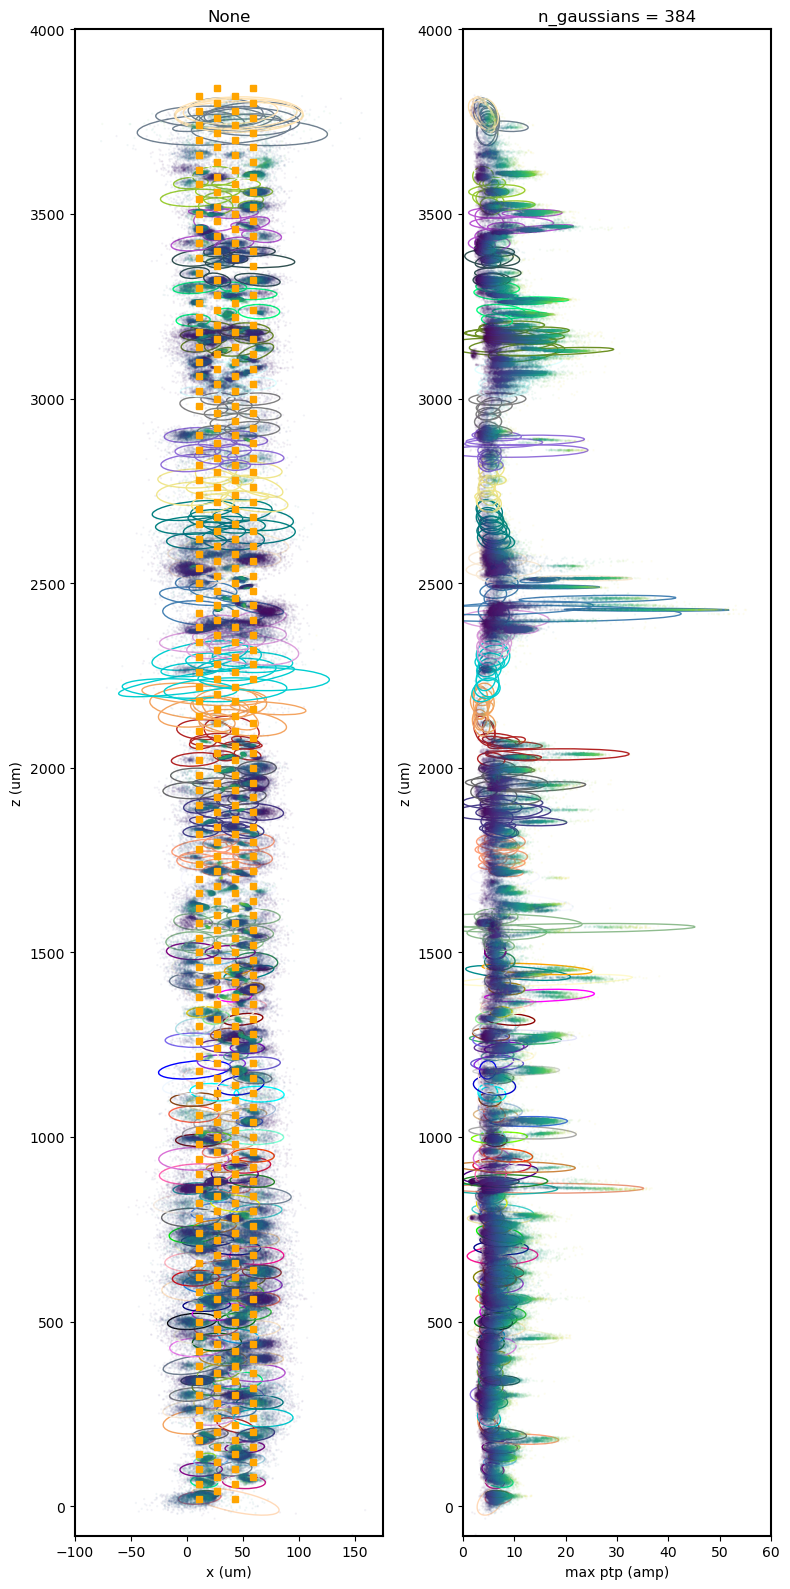

In [106]:
plot_gmm_cluster_bounds(sub_id, structured_unsorted, spikes_channels, np.unique(spikes_channels), display_all_spikes=False, n_spikes_display=5_000)

zoom in to see each one channel:

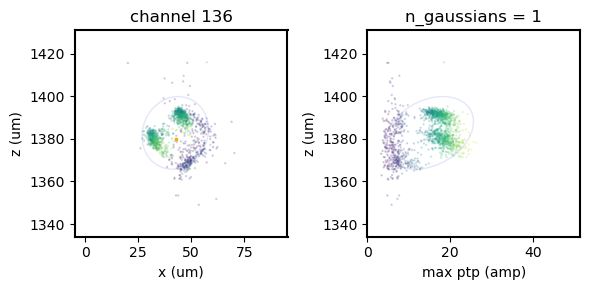

In [16]:
idx = np.unique(spikes_channels)[136] # 91, 99, 101, 116, 124, 126, 128, 134, 136, 138, 140,  
sub_spike_train = structured_unsorted[spikes_channels == idx]
plot_gmm_cluster_bounds(sub_id, structured_unsorted, spikes_channels, idx, channels=[idx], title='channel '+str(int(idx)), display_all_spikes=True, figure_size=(6,3))

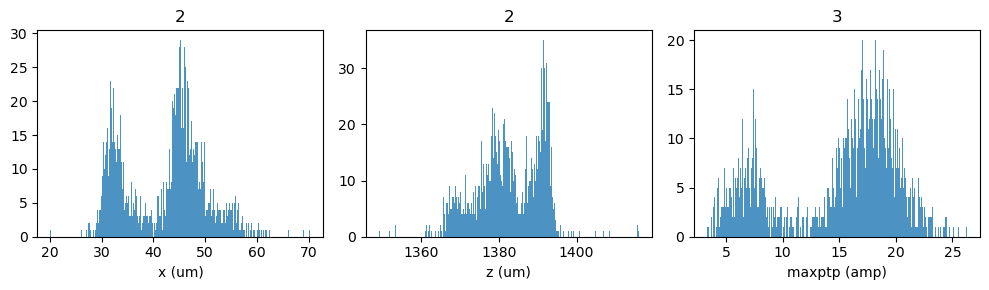

In [17]:
p_val = 0.05,
n_modes_x = len(UniDip(np.msort(sub_spike_train[:,0]), alpha=p_val).run())
n_modes_z = len(UniDip(np.msort(sub_spike_train[:,1]), alpha=p_val).run())
n_modes_ptp = len(UniDip(np.msort(sub_spike_train[:,2]), alpha=p_val).run())
n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])

fig, axes = plt.subplots(1,3, figsize=(10,3))
axes[0].hist(sub_spike_train[:,0], 300, alpha=.8)
axes[0].set_xlabel('x (um)')
axes[0].set_title(n_modes_x)
axes[1].hist(sub_spike_train[:,1], 300, alpha=.8)
axes[1].set_xlabel('z (um)')
axes[1].set_title(n_modes_z)
axes[2].hist(sub_spike_train[:,2], 300, alpha=.8)
axes[2].set_xlabel('maxptp (amp)')
axes[2].set_title(n_modes_ptp)
plt.tight_layout()
plt.show()

In [18]:
sub_gmm = GaussianMixture(n_components=n_gaussians, 
                          max_iter=1000, covariance_type='full',
                          # weight_concentration_prior_type='dirichlet_distribution',
                          init_params='kmeans', warm_start=False, verbose=0).fit(sub_spike_train)
sub_labels = sub_gmm.predict(sub_spike_train)

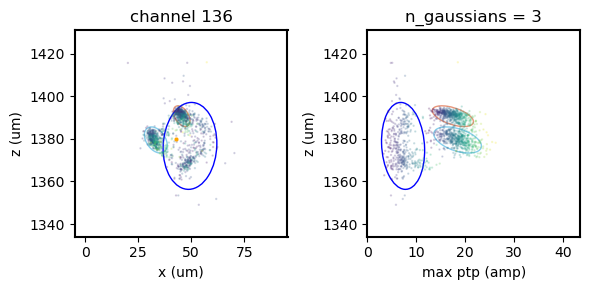

In [19]:
plot_gmm_cluster_bounds(sub_id, sub_spike_train, sub_labels, np.unique(sub_labels), channels=[idx], title='channel '+str(int(idx)), display_all_spikes=True, figure_size=(6,3))

In [13]:
multi_modal_dict = {}
sub_spike_train_lst = []
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []
p_val = .05
for label in np.unique(spikes_channels):
    sub_spike_train = structured_unsorted[spikes_channels == label]
    if len(sub_spike_train) > 2: # a minimum of 2 points required for MoG
        sub_spike_train_lst.append(sub_spike_train)
        n_modes_x = len(UniDip(np.msort(sub_spike_train[:,0]), alpha=p_val).run())
        n_modes_z = len(UniDip(np.msort(sub_spike_train[:,1]), alpha=p_val).run())
        n_modes_ptp = len(UniDip(np.msort(sub_spike_train[:,2]), alpha=p_val).run())
        n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])
        if n_gaussians > 1:
            print(f'unit {label} has {n_gaussians} modes ...')
            multi_modal_dict.update({label: n_gaussians})
        if n_gaussians >= 1:
            sub_gmm = GaussianMixture(n_components=n_gaussians, 
                              max_iter=1000,
                              covariance_type='full',
                              init_params='kmeans', warm_start=False, verbose=0)
            sub_gmm.fit(sub_spike_train)
            sub_labels = sub_gmm.predict(sub_spike_train)
            sub_weights = [np.sum(sub_labels == i)/len(structured_unsorted) for i in range(n_gaussians)]
            sub_weights_lst.append(sub_weights)
            sub_means_lst.append(sub_gmm.means_)
            sub_covs_lst.append(sub_gmm.covariances_)

unit 12.0 has 2 modes ...
unit 17.0 has 2 modes ...
unit 38.0 has 2 modes ...
unit 45.0 has 2 modes ...
unit 78.0 has 3 modes ...
unit 84.0 has 2 modes ...
unit 85.0 has 3 modes ...
unit 87.0 has 7 modes ...
unit 91.0 has 2 modes ...
unit 99.0 has 3 modes ...
unit 101.0 has 2 modes ...
unit 116.0 has 4 modes ...
unit 124.0 has 6 modes ...
unit 126.0 has 4 modes ...
unit 128.0 has 3 modes ...
unit 132.0 has 2 modes ...
unit 134.0 has 2 modes ...
unit 136.0 has 3 modes ...
unit 138.0 has 2 modes ...
unit 140.0 has 4 modes ...
unit 141.0 has 2 modes ...
unit 142.0 has 2 modes ...
unit 143.0 has 5 modes ...
unit 144.0 has 2 modes ...
unit 145.0 has 2 modes ...
unit 154.0 has 2 modes ...
unit 155.0 has 2 modes ...
unit 157.0 has 3 modes ...
unit 158.0 has 2 modes ...
unit 159.0 has 2 modes ...
unit 160.0 has 3 modes ...
unit 162.0 has 2 modes ...
unit 166.0 has 2 modes ...
unit 168.0 has 3 modes ...
unit 173.0 has 3 modes ...
unit 174.0 has 2 modes ...
unit 176.0 has 2 modes ...
unit 177.0 

In [14]:
multi_modal_ids = list(multi_modal_dict.keys())
uni_modal_ids = list(set(np.unique(spikes_channels)).difference(set(multi_modal_ids)))

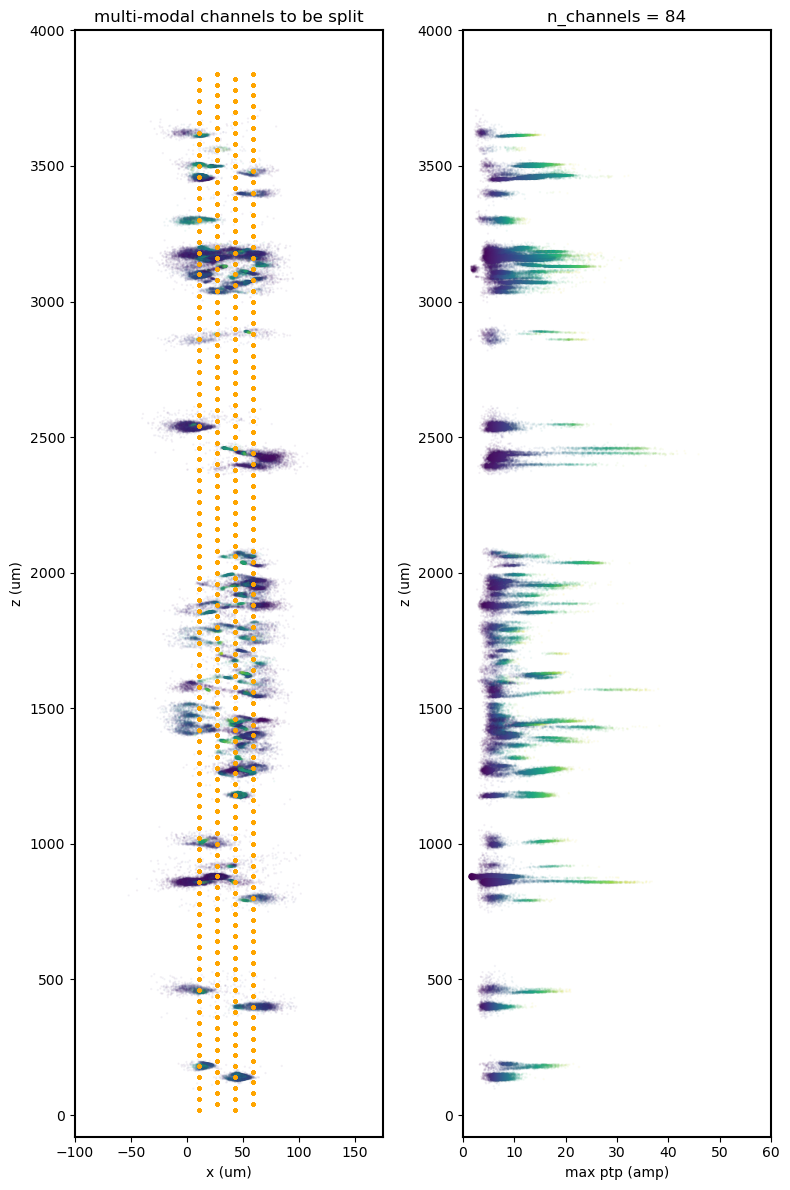

In [177]:
plot_gmm_cluster_bounds(sub_id, structured_unsorted, spikes_channels, multi_modal_ids, channels=np.unique(spikes_channels), title='multi-modal channels to be split', figure_size=(8,12), display_all_spikes=False)

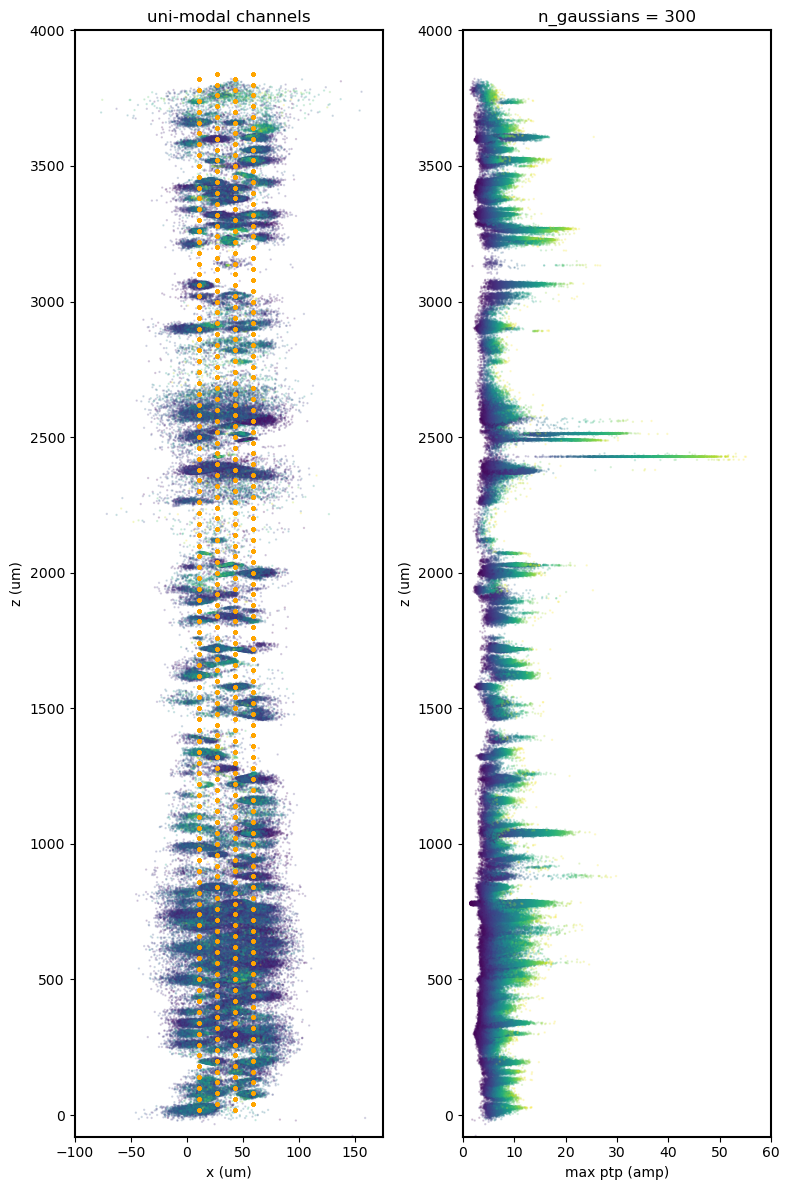

In [175]:
plot_gmm_cluster_bounds(sub_id, structured_unsorted, spikes_channels, uni_modal_ids, channels=np.unique(spikes_channels), title='uni-modal channels', figure_size=(8,12), display_all_spikes=True)

In [15]:
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

In [17]:
max_chan_gmm = GaussianMixture(n_components=len(sub_weights), covariance_type='full')
max_chan_gmm.weights_ = sub_weights
max_chan_gmm.means_ = sub_means
max_chan_gmm.covariances_ = sub_covs
max_chan_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sub_covs))

In [18]:
len(sub_weights)

530

In [23]:
max_chan_labels = max_chan_gmm.predict(structured_unsorted)
max_chan_probs = max_chan_gmm.predict_proba(structured_unsorted)

In [38]:
# np.save('../pretrained/dy009/max_chan_labels.npy', max_chan_labels)
# np.save('../pretrained/dy009/max_chan_probs.npy', max_chan_probs)

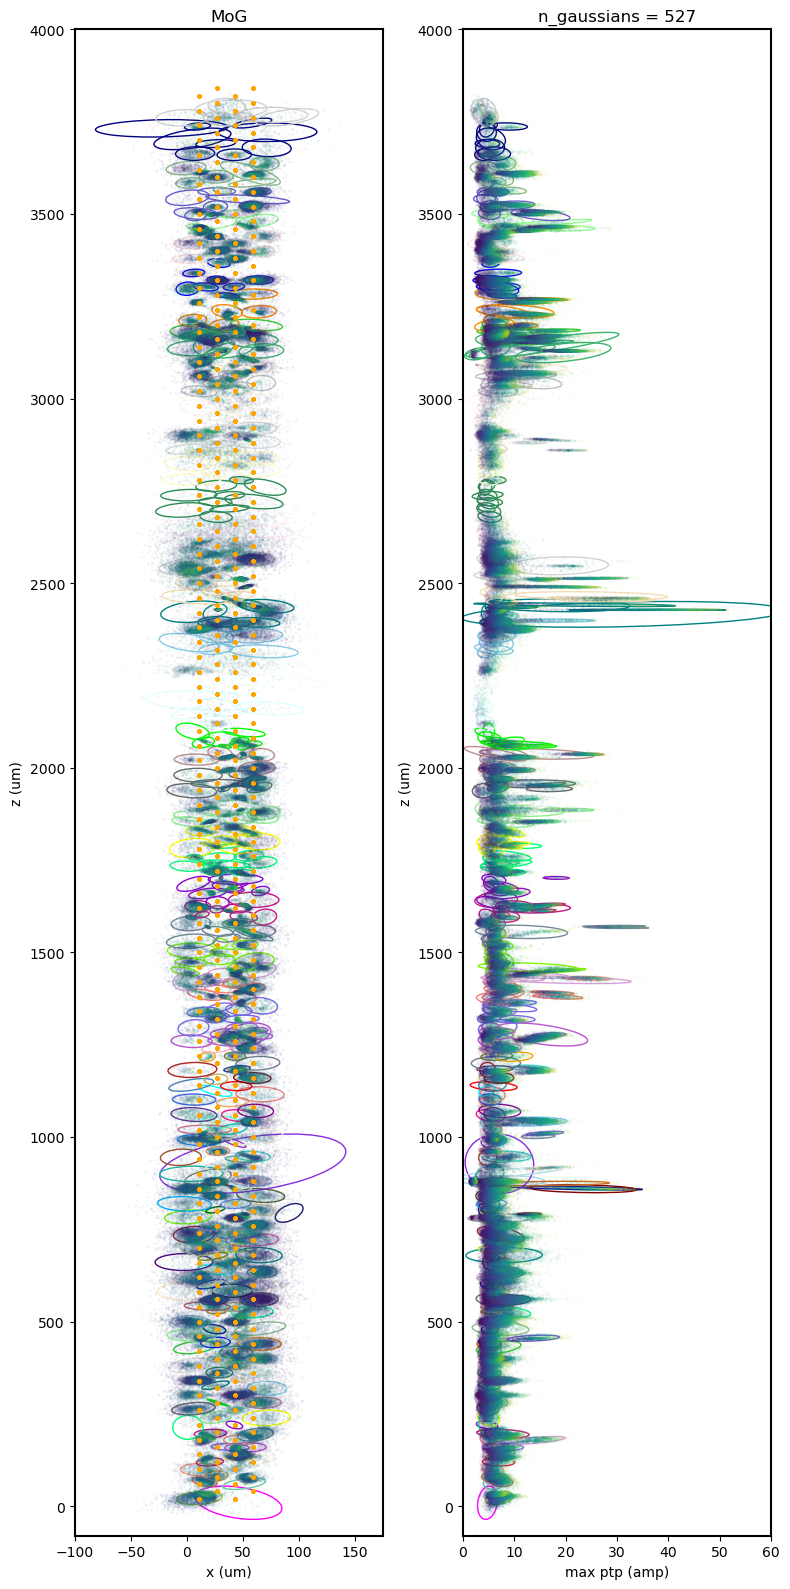

In [21]:
plot_gmm_cluster_bounds(sub_id, structured_unsorted, max_chan_labels, max_chan_labels, channels=np.unique(spikes_channels), title='MoG', display_all_spikes=False, n_spikes_display=5_000)

In [29]:
full_spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]
full_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:]

In [30]:
full_labels = max_chan_gmm.predict(full_unsorted)
full_probs = max_chan_gmm.predict_proba(full_unsorted)

In [31]:
clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((
    # spikes_times, max_chan_labels, max_chan_probs),
    full_spikes_times, full_labels, full_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 528, 30)
clusterless neural projections shape: (230, 528, 15)
clusterless neural reconstructions shape: (230, 528, 30)


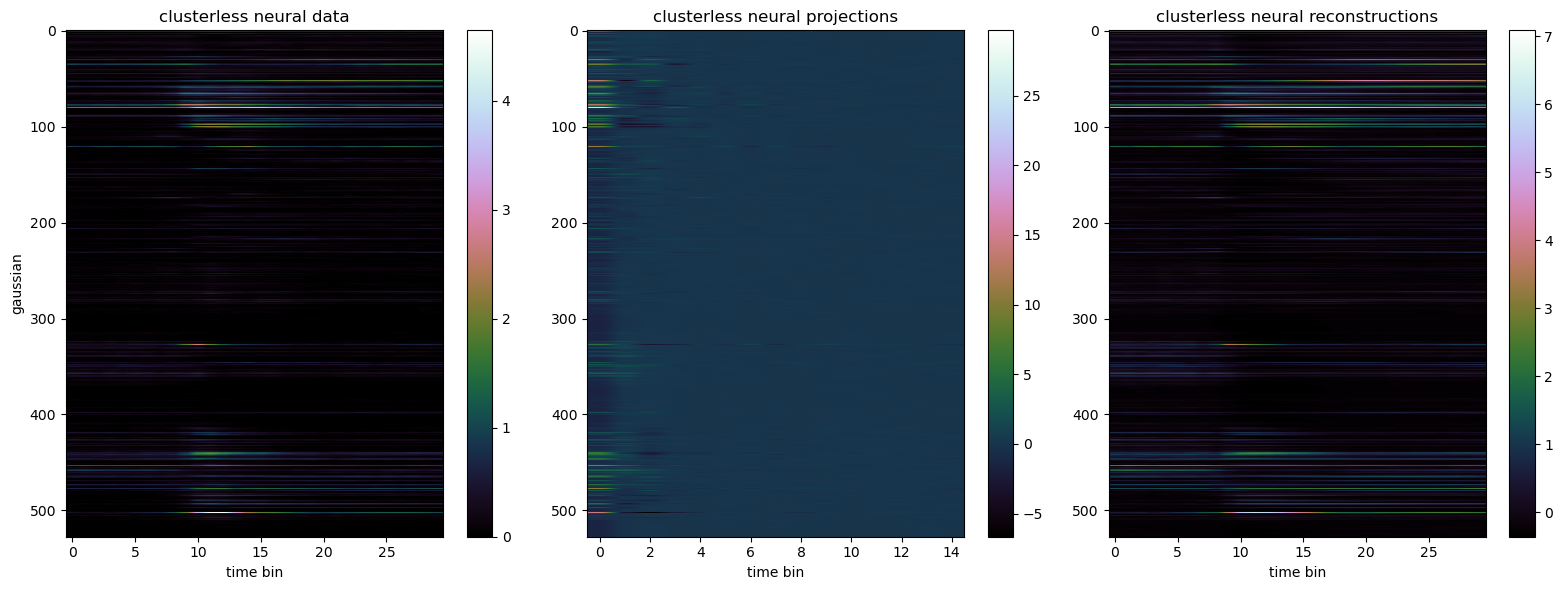

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [33]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.935 auc: 0.988
choice fold 2 test accuracy: 0.957 auc: 0.996
choice fold 3 test accuracy: 0.957 auc: 0.996
choice fold 4 test accuracy: 0.935 auc: 0.990
choice fold 5 test accuracy: 0.978 auc: 0.998
choice mean of 5-fold cv accuracy: 0.952 auc: 0.993
choice sd of 5-fold cv accuracy: 0.016 auc: 0.004
stimulus fold 1 test accuracy: 0.261 auc: 0.779
stimulus fold 2 test accuracy: 0.283 auc: 0.804
stimulus fold 3 test accuracy: 0.348 auc: 0.812
stimulus fold 4 test accuracy: 0.304 auc: 0.811
stimulus fold 5 test accuracy: 0.326 auc: 0.814
stimulus mean of 5-fold cv accuracy: 0.304 auc: 0.804
stimulus sd of 5-fold cv accuracy: 0.031 auc: 0.013


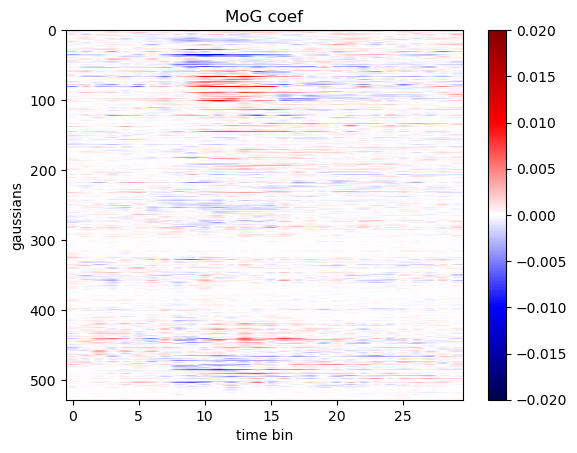

In [34]:
x = clusterless_neural_data.copy()
x = x.reshape(-1, x.shape[1]*x.shape[-1])
y = choices
decoder = LinearSVC(random_state=seed, max_iter=1e4, tol = 0.01, verbose=0)
decoder.fit(x, y.argmax(1))
coef = decoder.coef_.ravel().reshape(clusterless_neural_data.shape[1], 
                                     clusterless_neural_data.shape[-1])

p = plt.imshow(coef, aspect='auto', cmap='seismic', vmin=-0.02, vmax=0.02)
plt.title('MoG coef')
plt.xlabel('time bin')
plt.ylabel('gaussians')
plt.colorbar()
plt.show()

merge

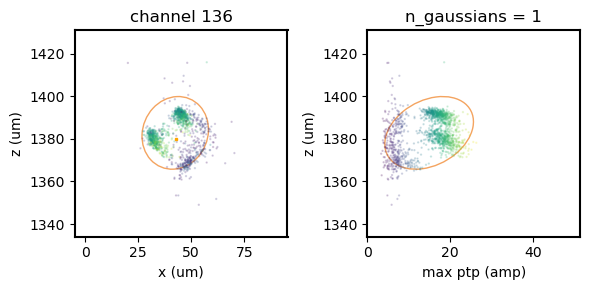

In [28]:
idx = np.unique(spikes_channels)[136] # 91, 99, 101, 116, 124, 126, 128, 134, 136, 138, 140,  
sub_spike_train = structured_unsorted[spikes_channels == idx]
plot_gmm_cluster_bounds(sub_id, structured_unsorted, spikes_channels, idx, channels=[idx], title='channel '+str(int(idx)), display_all_spikes=True, figure_size=(6,3))

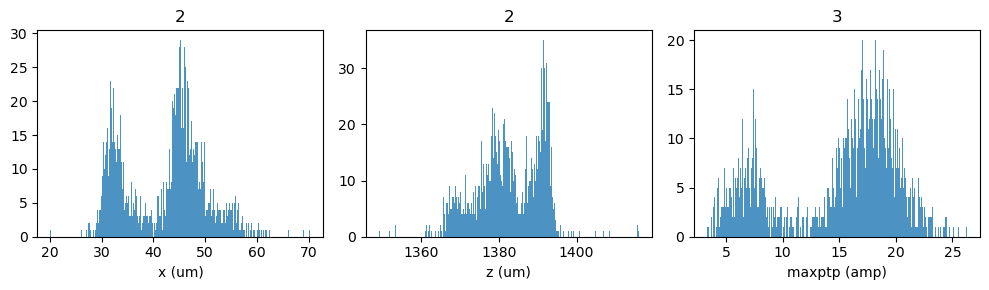

In [29]:
p_val = 0.05,
n_modes_x = len(UniDip(np.msort(sub_spike_train[:,0]), alpha=p_val).run())
n_modes_z = len(UniDip(np.msort(sub_spike_train[:,1]), alpha=p_val).run())
n_modes_ptp = len(UniDip(np.msort(sub_spike_train[:,2]), alpha=p_val).run())
n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])

fig, axes = plt.subplots(1,3, figsize=(10,3))
axes[0].hist(sub_spike_train[:,0], 300, alpha=.8)
axes[0].set_xlabel('x (um)')
axes[0].set_title(n_modes_x)
axes[1].hist(sub_spike_train[:,1], 300, alpha=.8)
axes[1].set_xlabel('z (um)')
axes[1].set_title(n_modes_z)
axes[2].hist(sub_spike_train[:,2], 300, alpha=.8)
axes[2].set_xlabel('maxptp (amp)')
axes[2].set_title(n_modes_ptp)
plt.tight_layout()
plt.show()

In [34]:
sub_gmm = GaussianMixture(n_components=n_gaussians, 
                          max_iter=1000, covariance_type='full',
                          init_params='kmeans', warm_start=False, verbose=0).fit(sub_spike_train)
sub_labels = sub_gmm.predict(sub_spike_train)
sub_probs = sub_gmm.predict_proba(sub_spike_train)

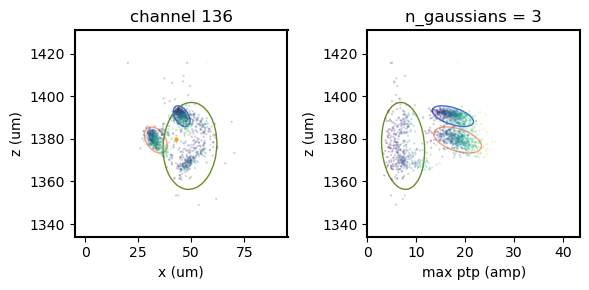

In [31]:
plot_gmm_cluster_bounds(sub_id, sub_spike_train, sub_labels, np.unique(sub_labels), channels=[idx], title='channel '+str(int(idx)), display_all_spikes=True, figure_size=(6,3))

In [22]:
from scipy.stats import entropy, wasserstein_distance

In [216]:
def calc_symmetric_kl_div(x, y):
    '''
    kl div only apply to distributions so normalize pdfs first.
    average kl both directions to get symmetrical kl div.
    '''
    norm_x = x / np.sum(x)
    norm_y = y / np.sum(y)
    # mask = np.logical_and(norm_x != 0, norm_y != 0)
    # norm_x = norm_x[mask]
    # norm_y = norm_y[mask]
    return np.mean([entropy(norm_x,norm_y), entropy(norm_y,norm_x)])

wasserstein_distance is a better choice as shown in the example here:\
-consistent with eye-balling findings\
-doesn't require distributions (no need to normalize) and only require empirical distributions\
-no need to deal with inf as the operation does not use log()\
-symmetrical unlike kl div\
-do not need to have the same number of points in each set\
-distributions do not have identical support\
-wasserstein must consider the relation of every point in one set to every point in the other\
-scipy.wasserstein_distance(u, v) allows us to specify weights for u and v so we can design an adaptive wasserstein distance that accounts for the sparsity in probe geometry\
https://datascience.stackexchange.com/questions/53478/how-to-find-out-if-two-datasets-are-close-to-each-other
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html

In [217]:
sub_gmm.means_

array([[  33.30473194, 1379.50194598,   18.48714573],
       [  45.46944306, 1390.68180065,   17.5076762 ],
       [  49.39185265, 1376.6952313 ,    7.3302165 ]])

In [218]:
print(calc_symmetric_kl_div(sub_probs[:,0], sub_probs[:,1]))
print(calc_symmetric_kl_div(sub_probs[:,0], sub_probs[:,2]))
print(calc_symmetric_kl_div(sub_probs[:,1], sub_probs[:,2]))

40.97233965863829
37.32753269200731
46.289687499954724


In [213]:
print(wasserstein_distance(sub_probs[:,0], sub_probs[:,1]))
print(wasserstein_distance(sub_probs[:,0], sub_probs[:,2]))
print(wasserstein_distance(sub_probs[:,1], sub_probs[:,2]))

0.028400082214290807
0.05359411532257661
0.0819923050106588


after computing pairwise distance metric, how to pick over-splits? \
-outlier detection using z score?

In [44]:
def calc_wasserstein_dist_matrix(probs, tol=0.1):
    '''
    to do: speed up this operation - parallel processing the for loop 
    '''
    pairs = []
    dist_mat = np.zeros((probs.shape[1], probs.shape[1]))
    for i in range(probs.shape[1]):
        for j in range(probs.shape[1]):
            if i != j:
                if set([i,j]) not in pairs:
                    pairs.append(set([i,j]))
                    u = probs[:,i].copy()
                    v = probs[:,j].copy()
                    dist = wasserstein_distance(u, v)
                    dist_mat[i, j] = dist
                    if np.logical_and(i % 1 == 0, j % 100 == 0):
                        print(f'calculaing wasserstein distance for pair ({i}, {j}) ...')
            elif i == j:
                dist_mat[i, j] = np.inf  # exclude self-connection
    return dist_mat

In [45]:
dist_mat = calc_wasserstein_dist_matrix(max_chan_probs)

calculaing wasserstein distance for pair (0, 100) ...
calculaing wasserstein distance for pair (0, 200) ...
calculaing wasserstein distance for pair (0, 300) ...
calculaing wasserstein distance for pair (0, 400) ...
calculaing wasserstein distance for pair (0, 500) ...
calculaing wasserstein distance for pair (1, 100) ...
calculaing wasserstein distance for pair (1, 200) ...
calculaing wasserstein distance for pair (1, 300) ...
calculaing wasserstein distance for pair (1, 400) ...
calculaing wasserstein distance for pair (1, 500) ...
calculaing wasserstein distance for pair (2, 100) ...
calculaing wasserstein distance for pair (2, 200) ...
calculaing wasserstein distance for pair (2, 300) ...
calculaing wasserstein distance for pair (2, 400) ...
calculaing wasserstein distance for pair (2, 500) ...
calculaing wasserstein distance for pair (3, 100) ...
calculaing wasserstein distance for pair (3, 200) ...
calculaing wasserstein distance for pair (3, 300) ...
calculaing wasserstein dista

In [24]:
# np.save('../pretrained/dy009/dist_mat.npy', dist_mat)
dist_mat = np.load('../pretrained/dy009/dist_mat.npy')

In [25]:
dist_mat[dist_mat == 0] = np.inf

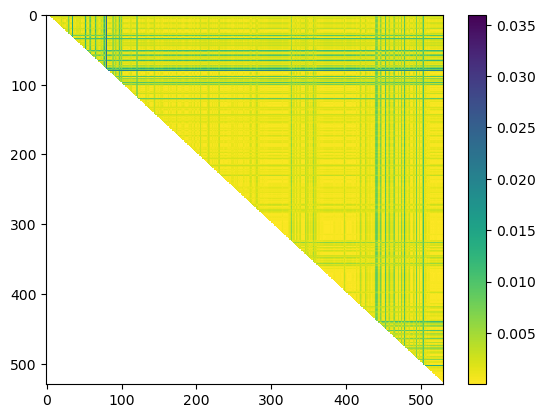

In [26]:
plt.imshow(dist_mat, aspect='auto', cmap='viridis_r')
plt.colorbar()
plt.show()

In [27]:
triu_indices = np.triu_indices_from(dist_mat)

In [28]:
dist_flat = dist_mat[triu_indices]

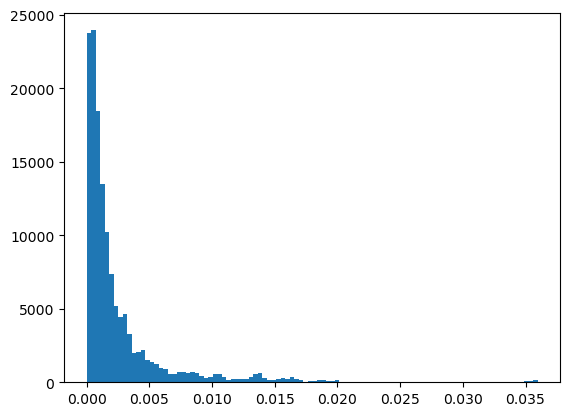

In [29]:
plt.hist(dist_flat[dist_flat != np.inf], 100);

In [30]:
np.sort(dist_flat)[:10]

array([3.20317899e-06, 5.61885228e-06, 5.70474349e-06, 6.00999018e-06,
       6.59462220e-06, 6.72390021e-06, 6.85240843e-06, 7.07771404e-06,
       7.47719881e-06, 7.50796205e-06])

In [35]:
np.argsort(dist_flat)[:20]

array([114613, 114616, 115518,   1368, 116938,  11541, 116120, 114163,
       114161, 116627, 116470, 114620, 114252,  59081, 112361, 114610,
       128491, 114840, 114846,  82586])

In [36]:
print(triu_indices[0][82586], triu_indices[1][82586])

189 371


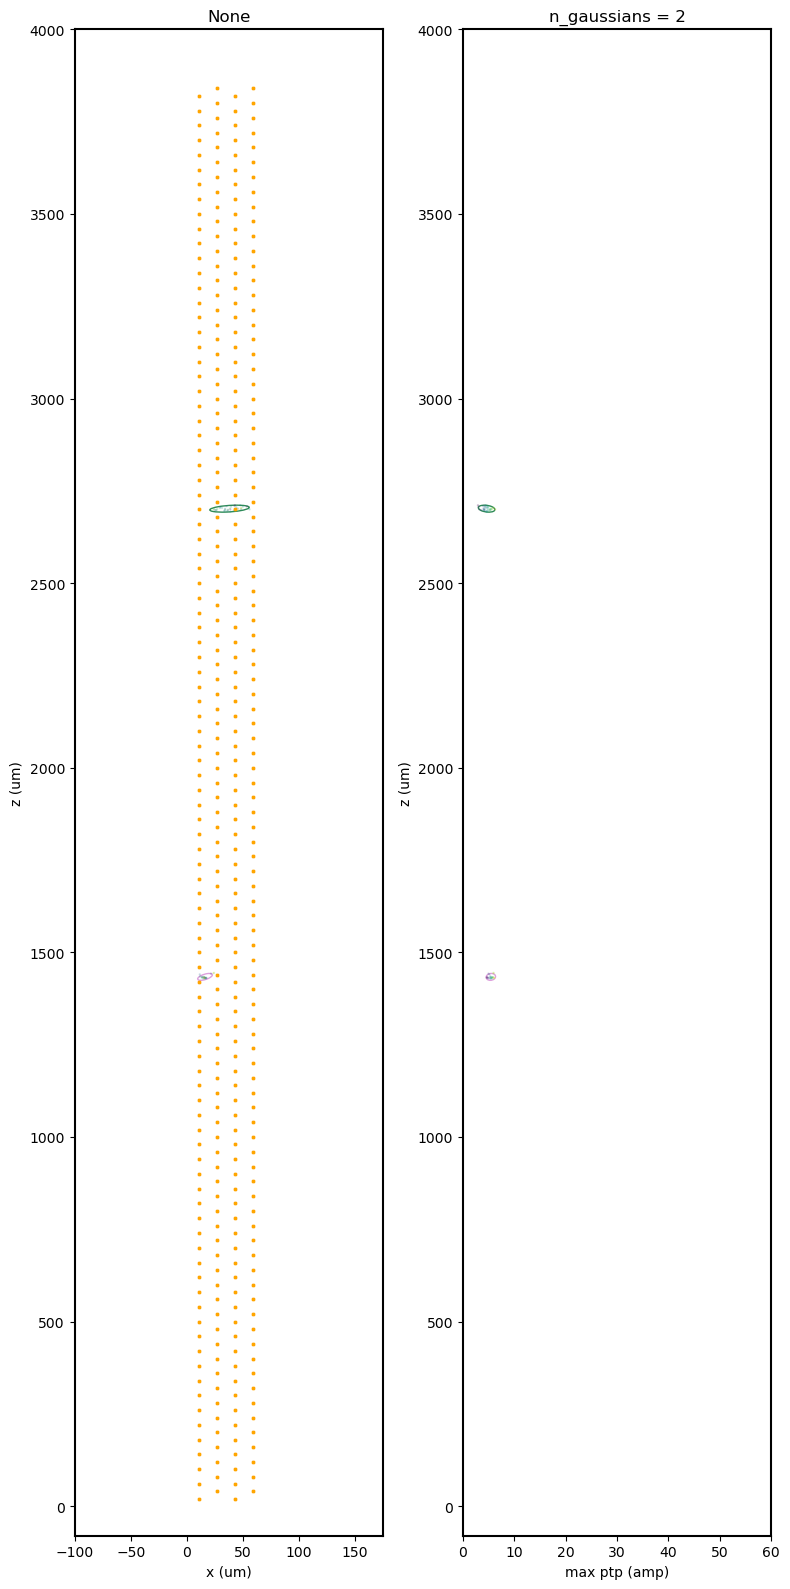

In [37]:
plot_gmm_cluster_bounds(sub_id, structured_unsorted, max_chan_labels, [189, 371], channels=np.unique(spikes_channels), display_all_spikes=True, n_spikes_display=5_000)

wasserstein's distance is not a good metric ...\
can use kl btw 2 gaussians (analytical):\
-https://statproofbook.github.io/P/mvn-kl.html \
-https://gist.github.com/ChuaCheowHuan/18977a3e77c0655d945e8af60633e4df

In [ ]:
def kl_mvn(m0, S0, m1, S1):
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0
    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N) 

can also use reverse unidip for merge:\
-if 2 gaussians are unimodal on (x, z, maxptp), merge them